In [29]:
# Menambahkan path untuk mengimpor modul dari direktori yang lebih tinggi
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))  # Menambahkan path ke direktori yang lebih tinggi

# Mengimpor pustaka yang dibutuhkan
import pickle  # Untuk menyimpan dan memuat objek Python
import numpy as np  # Untuk operasi numerik dengan array
import pandas as pd # Untuk operasi terkait Dataframe
import os  # Untuk operasi terkait file dan direktori
import torch.optim  # Untuk mengimpor optimizers dari PyTorch

# Mengimpor berbagai kelas model dari modul 'model'
from model.DDQN import DDQN_Agent  # Model Double Deep Q-Network (DDQN)
from model.DoubleDQN import DoubleDQN_Agent  # Model DoubleDQN
from model.DuellingDQN import DuellingDQN_Agent  # Model DuellingDQN
from model.DuellingDoubleDQN import D3QN_Agent  # Model Duelling Double DQN (D3QN)
from model.NoisyDQN import NoisyDQN_Agent  # Model Noisy DQN
from model.NoisyDuellingDoubleDQN import NoisyD3QN_Agent  # Model Noisy Duelling Double DQN (NoisyD3QN)
from model.DQN import DQN_Agent  # Model DQN (Deep Q-Network)
from model.ActorCritic import ActorCriticAgent  # Model Actor-Critic
from model.WD3QN import WD3QN_Agent  # Model Weighted Duelling Double DQN (WD3QN)

# Mengimpor fungsi evaluasi dan pengujian dari modul 'support_class.evaluate_general'
from support_class.evaluate_general import do_eval, do_test, do_eval_ac, do_test_ac

# Mengimpor fungsi untuk pengelompokan pasien dan generator trajektori dari modul 'support_class.data_util'
from support_class.data_util import patient_clustering, patient_clustering_test, trajectory_generator

# Mengimpor pustaka untuk visualisasi data
import matplotlib.pyplot as plt

# Menentukan perangkat yang digunakan (CPU atau GPU)
device = "cpu"  # Menetapkan 'cpu' sebagai perangkat
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Dapat mengganti ke GPU jika tersedia
# print(f"Using device: {device}")  # Mencetak perangkat yang digunakan

# Mengimpor fungsi untuk normalisasi data (z-score) dari scipy
from scipy.stats import zscore, rankdata

# Membuat fungsi normalisasi z-score kustom
def my_zscore(x):
    return zscore(x, ddof=1), np.mean(x, axis=0), np.std(x, axis=0, ddof=1)  
    # Mengembalikan nilai z-score, rata-rata, dan deviasi standar dari array x


In [30]:
####################### Parameter Settings ############################
print('####  PARAMETER SETTINGS  ####')
num_epoch = 101  # nr of training cycles
gamma = 0.99
# beat1 = 0
# beat2 = 0.6
# beta3 = 0.3
ncv = 5  # nr of crossvalidation runs (each is 80% training / 20% test)
nra = 5
#lr = 1e-5
# reward_value = 24
# beta = [beat1, beat2, beta3]
# Define parameters

ncl=50             # nr of states
n_patient = 2            # nr of patient clusters
nclustering=32       # how many times we do clustering (best solution will be chosen) % 32
prop=0.25            # proportion of the data we sample for clustering
n_components = 5     # nr of pca components
random_state = 42    # for reproducibility
transthres=5         # threshold for pruning the transition matrix
outcome = 9
mimic_type = 4
save_path = f'../../result/mimic{mimic_type}/{n_patient}_cluster/{ncl}_states'
os.makedirs(save_path, exist_ok=True)  # Create the folder if it doesn't exist

if mimic_type == 3:
  print('####  LOAD DATA MIMIC-III ####')
  with open('../../data/step_4_start.pkl', 'rb') as file:
    MIMICtable = pickle.load(file)

  train = np.load('../../data/train.npy')
  validat = np.load('../../data/validation.npy')
  test = np.load('../../data/test.npy')
else:
  print('####  LOAD DATA MIMIC-IV ####')
  with open('../../data/step_4_start_mimiciv.pkl', 'rb') as file:
    MIMICtable = pickle.load(file)

  train = np.load('../../data/train_mimiciv.npy')
  validat = np.load('../../data/validation_mimiciv.npy')
  test = np.load('../../data/test_mimiciv.npy')

####  PARAMETER SETTINGS  ####
####  LOAD DATA MIMIC-IV ####


In [32]:
# Load MIMIC data (assuming it's a DataFrame)
if mimic_type == 3:
    icustayidlist = MIMICtable['icustayid']
else:
    icustayidlist = MIMICtable['stay_id']
icuuniqueids = np.unique(icustayidlist)  # Unique ICU stay IDs
reformat5 = MIMICtable.values.copy()  # Convert DataFrame to NumPy array

######################## Define States ###############################
print('####  DEFINE STATES  ####')

# 37 State Features
# colnorm = ['SOFA', 'age', 'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'Temp_C',
#            'Sodium', 'Chloride', 'Glucose', 'Calcium', 'Hb', 'WBC_count', 'Platelets_count',
#            'PTT', 'PT', 'Arterial_pH', 'paO2', 'paCO2', 'HCO3', 'Arterial_lactate', 'Shock_Index',
#            'PaO2_FiO2', 'cumulated_balance', 'CO2_mEqL', 'Ionised_Ca']
# collog = ['SpO2', 'BUN', 'Creatinine', 'SGOT', 'Total_bili', 'INR', 'input_total', 'output_total']

colbin = ['max_dose_vaso']
colnorm = ['SOFA', 'age', 'GCS', 'Weight_kg', 'Platelets_count', 'PT', 'PTT', 'Albumin', 'WBC_count', 
           'Arterial_lactate', 'Creatinine', 'HCO3', 'Ionised_Ca', 'Arterial_BE', 'Arterial_pH', 
           'Sodium', 'SGPT', 'Shock_Index', 'cumulated_balance', 'Chloride', 'Hb', 'paCO2', 
           'CO2_mEqL', 'PaO2_FiO2', 'Calcium', 'paO2', 'RR']

collog = ['BUN', 'INR', 'SGOT', 'Total_bili', 'output_4hourly', 'input_total', 'SpO2', 'output_total', 'elixhauser']

colbin=np.where(np.isin(MIMICtable.columns,colbin))[0]
colnorm = np.where(np.isin(MIMICtable.columns, colnorm))[0]
collog = np.where(np.isin(MIMICtable.columns, collog))[0]

scaleMIMIC = np.concatenate([reformat5[:, colbin]-0.5, zscore(reformat5[:, colnorm], ddof=1),
 zscore(np.log(0.1 + reformat5[:, collog]), ddof=1)], axis=1)

Xtrain = scaleMIMIC[train, :]
blocstrain = reformat5[train, 0]  # bloc
ptidtrain = reformat5[train, 1]  # patient id

Xvalidat = scaleMIMIC[validat, :]
blocsvalidat = reformat5[validat, 0]
ptidvalidat = reformat5[validat, 1]

Xtest = scaleMIMIC[test, :]
bloctest = reformat5[test, 0]
ptidtest = reformat5[test, 1]

Xvaltest = scaleMIMIC[~train, :]
blocvaltest = reformat5[~train, 0]
ptidvaltest = reformat5[~train, 1]

# *************************
RNNstate = Xtrain  # ***


######################## Define Action ###############################
print('####  DEFINE ACTION  ####')
nact = nra * nra  # 5*5=25
iol = MIMICtable.columns.get_loc('input_4hourly')  # input column
vcl = MIMICtable.columns.get_loc('max_dose_vaso')  # Column for the maximum amount of pressurized medicine used

a = reformat5[:, iol].copy()  # IV fluid
if a[a > 0].size > 0:
  a = rankdata(a[a > 0]) / a[a > 0].shape[0]
a = rankdata(a[a > 0]) / a[a > 0].shape[0]  # excludes zero fluid (will be action 1)
iof = np.floor((a + 0.2499999999) * 4)  # converts iv volume in 4 actions
a = reformat5[:, iol].copy()
a = np.where(a > 0)[0]  # location of non-zero fluid in big matrix
io = np.ones((reformat5.shape[0], 1))  # array of ones, by default
io[a] = (iof + 1).reshape(-1, 1)  # where more than zero fluid given: save actual action
io = io.ravel()

vc = reformat5[:, vcl].copy()
vcr = rankdata(vc[vc != 0]) / vc[vc != 0].size
vcr = np.floor((vcr + 0.249999999999) * 4)  # converts to 4 bins
vcr[vcr == 0] = 1
vc[vc != 0] = vcr + 1
vc[vc == 0] = 1

ma1 = np.array([np.median(reformat5[io == 1, iol]), np.median(reformat5[io == 2, iol]), np.median(reformat5[io == 3, iol]),
              np.median(reformat5[io == 4, iol]), np.median(reformat5[io == 5, iol])])  # median dose of drug in all bins
ma2 = np.array([np.median(reformat5[vc == 1, vcl]), np.median(reformat5[vc == 2, vcl]), np.median(reformat5[vc == 3, vcl]),
              np.median(reformat5[vc == 4, vcl]), np.median(reformat5[vc == 5, vcl])])

med = np.concatenate([io.reshape(-1, 1), vc.reshape(-1, 1)], axis=1)
_, actionbloc = np.unique(med, axis=0, return_inverse=True)

####  DEFINE STATES  ####
####  DEFINE ACTION  ####


In [33]:

Y90 = reformat5[train, outcome]
Y90_validat = reformat5[validat, outcome]
Y90_test = reformat5[test, outcome]
Y90_valtest = reformat5[~train, outcome]

actionbloctrain = actionbloc[train]  # ***
actionblocvalidat = actionbloc[validat]  # ***
actionbloctest = actionbloc[test]  # ***
actionblocvaltest = actionbloc[~train]



In [37]:
patient_clusters_train = patient_clustering(save_path, "train", Xtrain, blocstrain, ptidtrain, MIMICtable, ncl, nclustering, prop, actionbloctrain, Y90, n_patient, n_components, random_state)
patient_clusters_valtest = patient_clustering(save_path, "valtest", Xvaltest, blocvaltest, ptidvaltest, MIMICtable, ncl, nclustering, prop, actionblocvaltest, Y90_valtest, n_patient, n_components, random_state)
patient_clusters_validat = patient_clustering(save_path, "validat", Xvalidat, blocsvalidat, ptidvalidat, MIMICtable, ncl, nclustering, prop, actionblocvalidat, Y90_validat, n_patient, n_components, random_state)
patient_clusters_test = patient_clustering_test(save_path, "test", Xtest, bloctest, ptidtest, MIMICtable, ncl, nclustering, prop, actionbloctest, Y90_test, n_patient, n_components, random_state)
patient_clusters_test = patient_clusters_test.reset_index()

train_batchs = trajectory_generator(reformat5, train, Xtrain, actionbloctrain, blocstrain, reformat5[train, 9], reformat5[train, 57])
validat_batchs = trajectory_generator(reformat5, validat, Xvalidat, actionblocvalidat, blocsvalidat, reformat5[validat, 9], reformat5[validat, 57])
valtest_batch = trajectory_generator(reformat5, ~train, Xvaltest, actionblocvaltest, blocvaltest, reformat5[validat+test, 9], reformat5[validat+test, 57])
test_batchs = trajectory_generator(reformat5, test, Xtest, actionbloctest, bloctest, reformat5[test, 9], reformat5[test, 57])

Patient Cluster
0     60510
1    248636
Name: count, dtype: int64


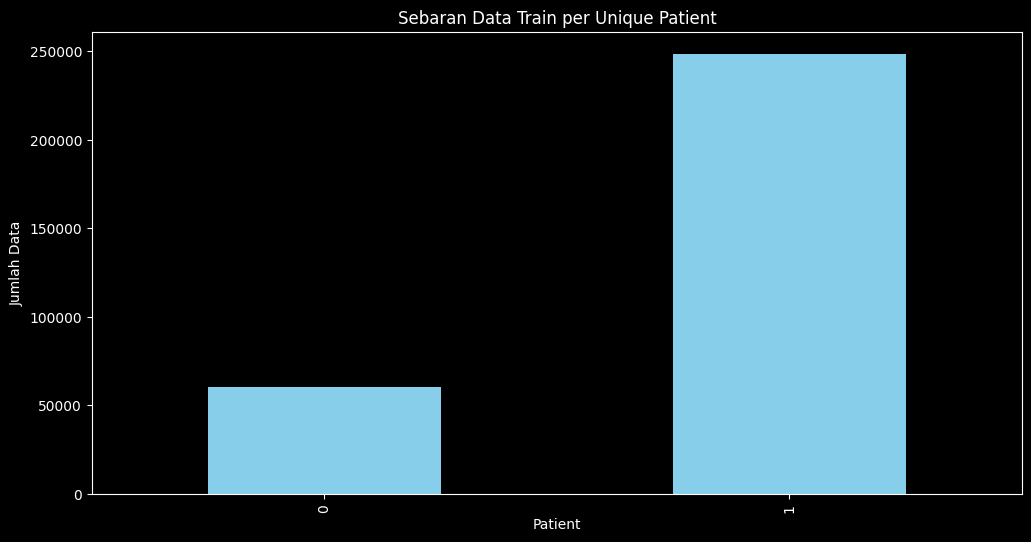

In [41]:
# Hitung sebaran data per unique State
patient_distribution = patient_clusters_train["Patient Cluster"].value_counts().sort_index()

# Tampilkan hasil
print(patient_distribution)
plt.figure(figsize=(12, 6))
patient_distribution.plot(kind="bar", color="skyblue")
plt.xlabel("Patient")
plt.ylabel("Jumlah Data")
plt.title("Sebaran Data Train per Unique Patient")
plt.xticks(rotation=90)
plt.show()

Patient Cluster
0    41367
1    36541
Name: count, dtype: int64


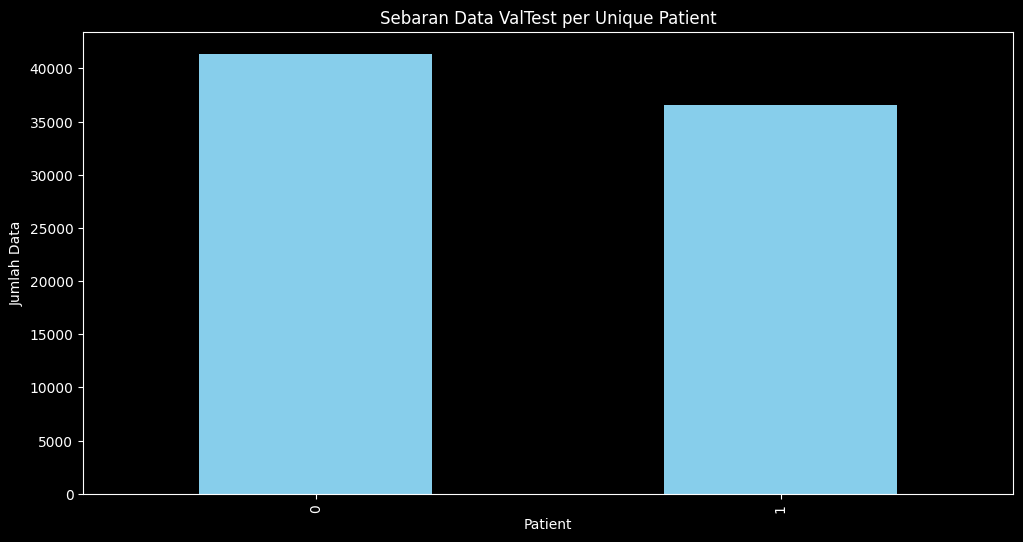

In [42]:
# Hitung sebaran data per unique State
patient_distribution = patient_clusters_valtest["Patient Cluster"].value_counts().sort_index()

# Tampilkan hasil
print(patient_distribution)
plt.figure(figsize=(12, 6))
patient_distribution.plot(kind="bar", color="skyblue")
plt.xlabel("Patient")
plt.ylabel("Jumlah Data")
plt.title("Sebaran Data ValTest per Unique Patient")
plt.xticks(rotation=90)
plt.show()

Patient Cluster
0    22106
1    17145
Name: count, dtype: int64


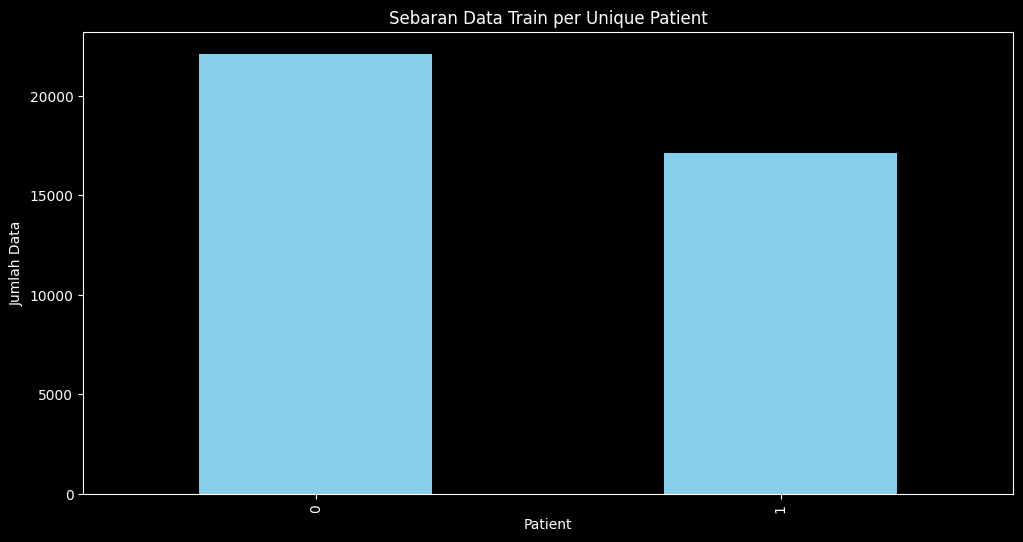

In [43]:
# Hitung sebaran data per unique State
patient_distribution = patient_clusters_validat["Patient Cluster"].value_counts().sort_index()

# Tampilkan hasil
print(patient_distribution)
plt.figure(figsize=(12, 6))
patient_distribution.plot(kind="bar", color="skyblue")
plt.xlabel("Patient")
plt.ylabel("Jumlah Data")
plt.title("Sebaran Data Train per Unique Patient")
plt.xticks(rotation=90)
plt.show()

Patient Cluster
0    21450
1    17207
Name: count, dtype: int64


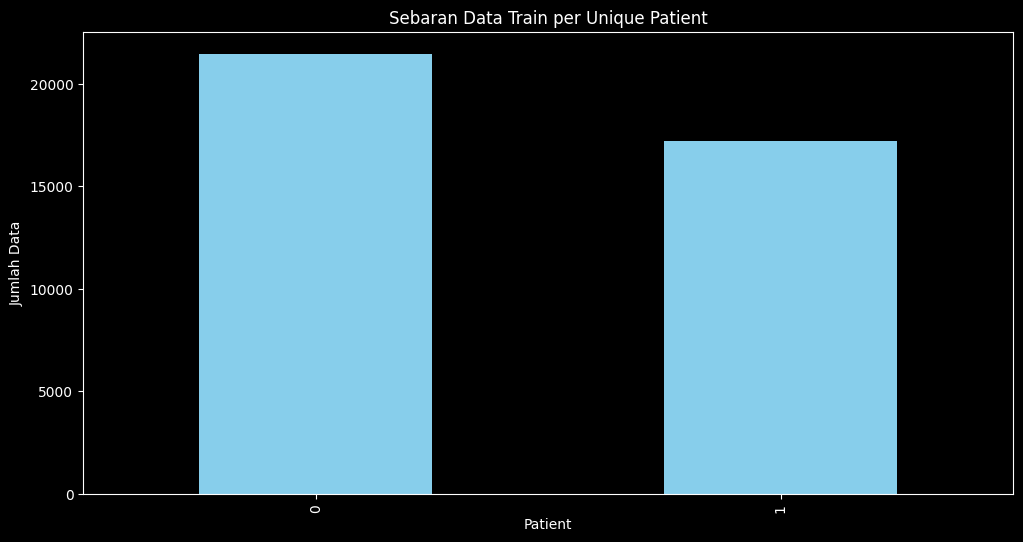

In [44]:
# Hitung sebaran data per unique State
patient_distribution = patient_clusters_test["Patient Cluster"].value_counts().sort_index()

# Tampilkan hasil
print(patient_distribution)
plt.figure(figsize=(12, 6))
patient_distribution.plot(kind="bar", color="skyblue")
plt.xlabel("Patient")
plt.ylabel("Jumlah Data")
plt.title("Sebaran Data Train per Unique Patient")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Define models for different algorithms
models = {
    "DistDQN": [DDQN_Agent() for _ in range(n_patient)],
    "DoubleDQN": [DoubleDQN_Agent() for _ in range(n_patient)],
    "DuellingDQN": [DuellingDQN_Agent() for _ in range(n_patient)],
    "DuellingDoubleDQN": [D3QN_Agent() for _ in range(n_patient)],
    "NoisyDQN": [NoisyDQN_Agent() for _ in range(n_patient)],
    "NoisyDuellingDoubleDQN": [NoisyD3QN_Agent() for _ in range(n_patient)]
}

# Record lists for comparison
record_loss_z = {model_name: [] for model_name in models.keys()}
record_phys_q = {model_name: [] for model_name in models.keys()}
record_agent_q = {model_name: [] for model_name in models.keys()}

# Initialize storage for metrics per model
phys_q_total = {model_name: np.empty((0,)) for model_name in models.keys()}
agent_q_total = {model_name: np.empty((0,)) for model_name in models.keys()}
record_loss_total = {model_name: np.empty((0,)) for model_name in models.keys()}

save_dir_model = os.path.join(save_path, 'model_saved/')
os.makedirs(save_dir_model, exist_ok=True)

for epoch in range(num_epoch):

    for model_name in models.keys():
        phys_q_total[model_name] = np.empty((0,))
        agent_q_total[model_name] = np.empty((0,))
        record_loss_total[model_name] = np.empty((0,))

    # Iterate through each cluster
    for model_name, model_list in models.items():
        print(f"============== {model_name} ==============")
        # Training each model
        for cluster in patient_clusters_train['Patient Cluster'].unique():
            train_indices = patient_clusters_train[patient_clusters_train['Patient Cluster'] == cluster].index
            test_indices = patient_clusters_test[patient_clusters_test['Patient Cluster'] == cluster].index

            train_batch_data = tuple(data[train_indices] for data in train_batchs)
            test_batch_data = tuple(data[test_indices] for data in test_batchs)
            model = model_list[int(cluster)]

            # Train the model
            record = model.train(train_batch_data, epoch)
            if model_name == 'ActorCritic':
                record_loss_total[model_name] = np.concatenate((record_loss_total[model_name], record[0]), axis=0)
            else:
                record_loss_total[model_name] = np.concatenate((record_loss_total[model_name], record), axis=0)

            # Save model periodically
            if epoch % 20 == 0:
                torch.save({
                    'actor_state_dict': model.actor.state_dict() if hasattr(model, 'actor') else None,
                    'critic_state_dict': model.critic.state_dict() if hasattr(model, 'critic') else None,
                    'Q_state_dict': model.Q.state_dict() if hasattr(model, 'Q') else None,
                    'Q_target_state_dict': model.Q_target.state_dict() if hasattr(model, 'Q_target') else None
                }, os.path.join(save_dir_model, f'{model_name}_{int(cluster)}_{epoch}.pt'))

            # Validation
            if model_name == 'ActorCritic':
                q_output, agent_actions, phys_actions, _ = do_eval_ac(model, test_batch_data)
                agent_actions = np.array(agent_actions, dtype=int)
                phys_actions = np.array(phys_actions, dtype=int)

                agent_q = q_output[agent_actions].detach().numpy()
                phys_q = q_output[phys_actions].detach().numpy() 
                 
                # Concatenate results for metrics
                if agent_q.size > 0:
                    agent_q_total[model_name] = np.concatenate((agent_q_total[model_name], agent_q[0]), axis=0)
                if phys_q.size > 0:
                    phys_q_total[model_name] = np.concatenate((phys_q_total[model_name], phys_q[0]), axis=0)
            else:
                q_output, agent_actions, phys_actions, _ = do_eval(model, test_batch_data)
                agent_actions = np.array(agent_actions, dtype=int)
                phys_actions = np.array(phys_actions, dtype=int)

                agent_q = q_output[np.arange(len(q_output)), agent_actions].detach().numpy()
                phys_q = q_output[np.arange(len(q_output)), phys_actions].detach().numpy()  

                # Concatenate results for metrics
                if agent_q.size > 0:
                    agent_q_total[model_name] = np.concatenate((agent_q_total[model_name], agent_q), axis=0)
                if phys_q.size > 0:
                    phys_q_total[model_name] = np.concatenate((phys_q_total[model_name], phys_q), axis=0)

        cluster_q_means = [] 
        for cluster in patient_clusters_train['Patient Cluster'].unique():
            valid_indices = np.intersect1d(patient_clusters_train.index[patient_clusters_train['Patient Cluster'] == cluster],
                                        np.arange(len(agent_q_total[model_name])))
            if valid_indices.size > 0:
                cluster_q = agent_q_total[model_name][valid_indices]
                cluster_q_means.append(np.mean(cluster_q))
            else:
                print(f"⚠️ Warning: No data for Cluster {cluster}, skipping.")

        if cluster_q_means:
            record_agent_q[model_name].append(np.mean(cluster_q_means))
        record_phys_q[model_name].append(np.mean(phys_q_total[model_name]))
        record_loss_z[model_name].append(np.mean(record_loss_total[model_name]))

    # After each epoch, print the comparison of the models in a table format
    print(f"\nEpoch {epoch}:")
    
    # Create a DataFrame to format the comparison as a table
    comparison_data = []
    for model_name in models.keys():
        comparison_data.append({
            "Model": model_name,
            "Mean Agent Q": np.mean(record_agent_q[model_name]),
            "Mean Phys Q": np.mean(record_phys_q[model_name]),
            "Loss": np.mean(record_loss_z[model_name])
        })
    
    # Convert to a pandas DataFrame for better formatting
    df_comparison = pd.DataFrame(comparison_data)
    
    # Print the table for this epoch
    print(df_comparison)

============== DistDQN ==============
Epoch : 0 Batch : 0 Average Loss : 2.081681966781616
Epoch : 0 Batch : 25 Average Loss : 2.1116492381462684
Epoch : 0 Batch : 50 Average Loss : 2.088190810353148
Epoch : 0 Batch : 75 Average Loss : 2.088362024018639
Epoch : 0 Batch : 100 Average Loss : 2.0846397558061205
Epoch : 0 Batch : 125 Average Loss : 2.073151614930895
Epoch : 0 Batch : 0 Average Loss : 2.6874566078186035
Epoch : 0 Batch : 25 Average Loss : 2.603891473550063
============== DoubleDQN ==============
Epoch : 0 Batch : 0 Average Loss : 2.1673226356506348
Epoch : 0 Batch : 25 Average Loss : 2.1551578503388624
Epoch : 0 Batch : 50 Average Loss : 2.113105706140107
Epoch : 0 Batch : 75 Average Loss : 2.101543763750478
Epoch : 0 Batch : 100 Average Loss : 2.0920527724936457
Epoch : 0 Batch : 125 Average Loss : 2.067856520887405
Epoch : 0 Batch : 0 Average Loss : 2.7713921070098877
Epoch : 0 Batch : 25 Average Loss : 2.6278674877606907
============== DuellingDQN ==============
Epoch : 

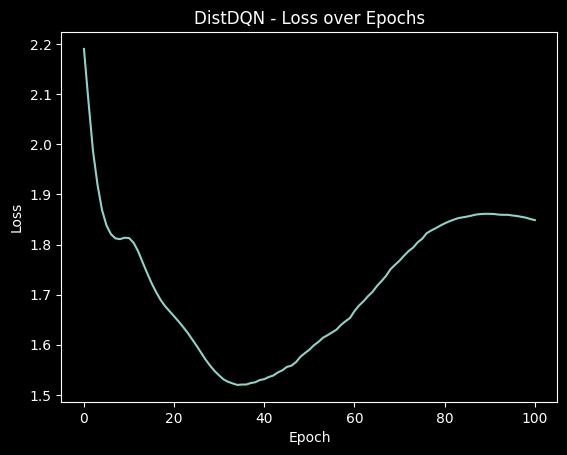

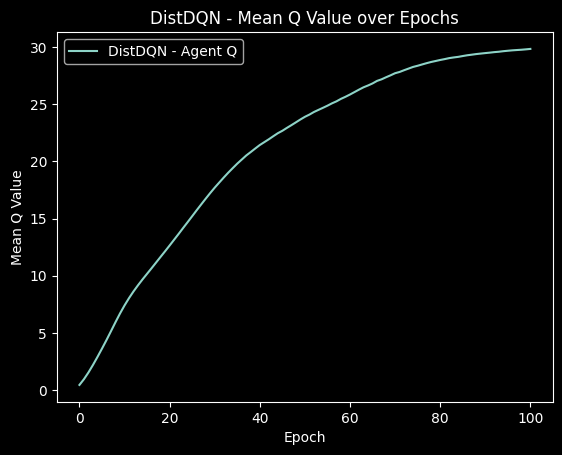

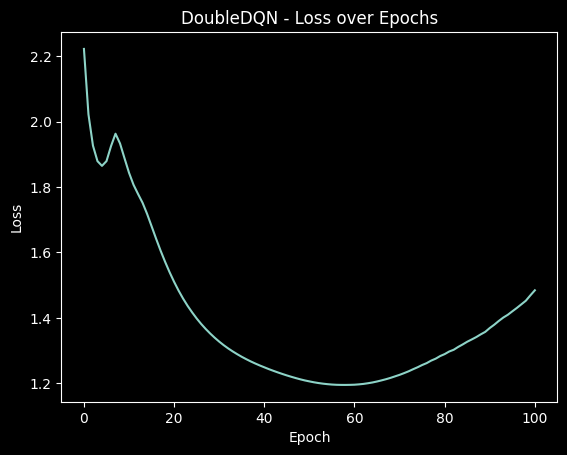

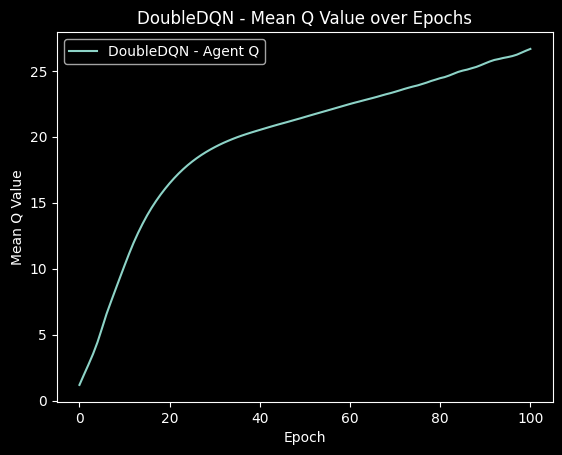

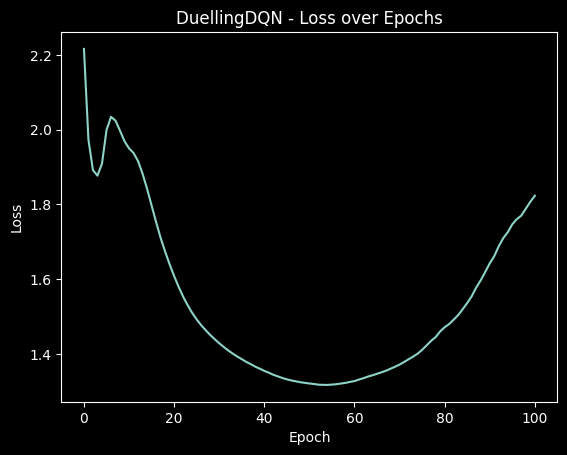

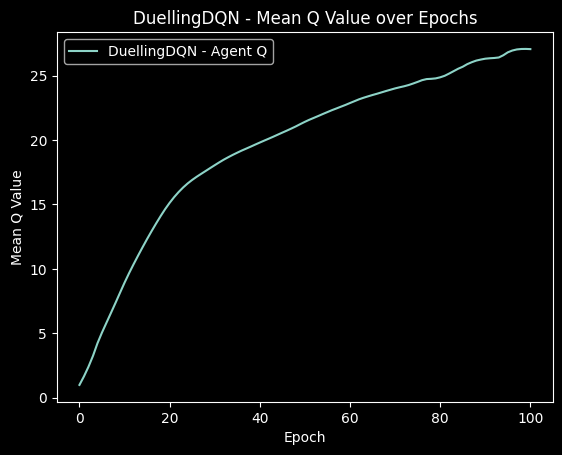

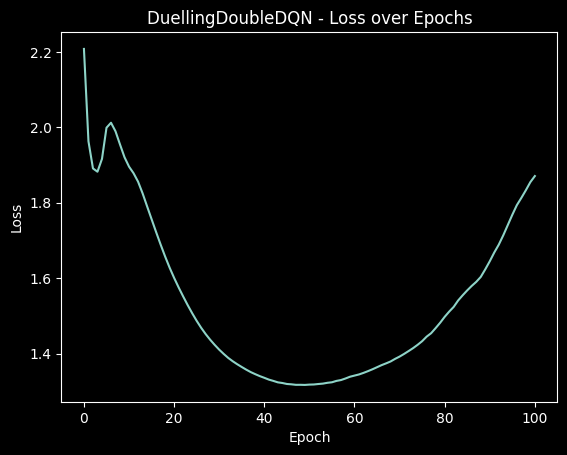

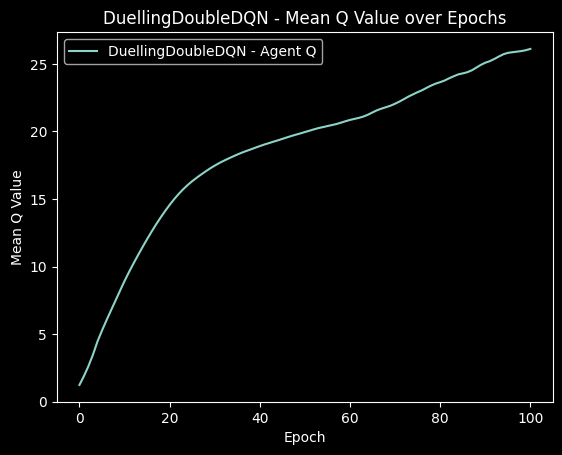

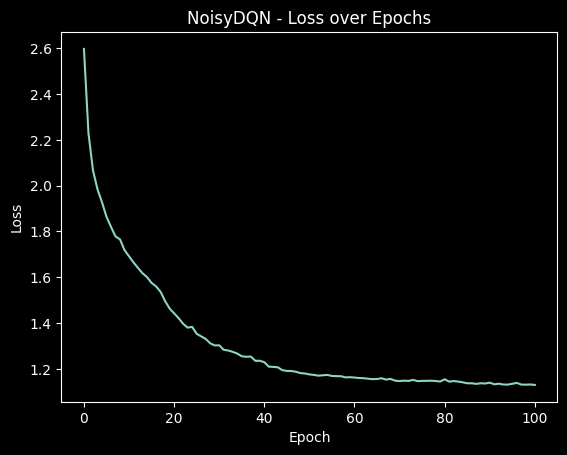

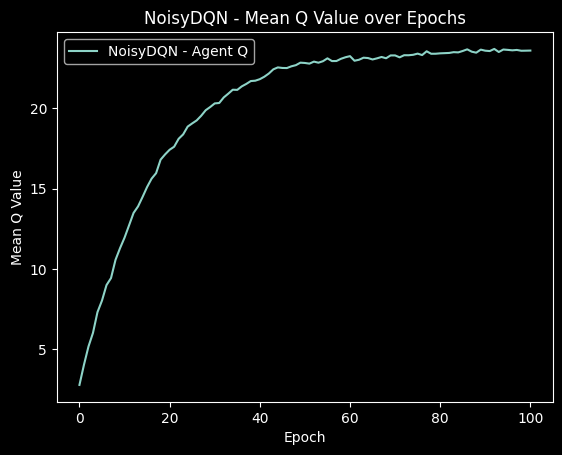

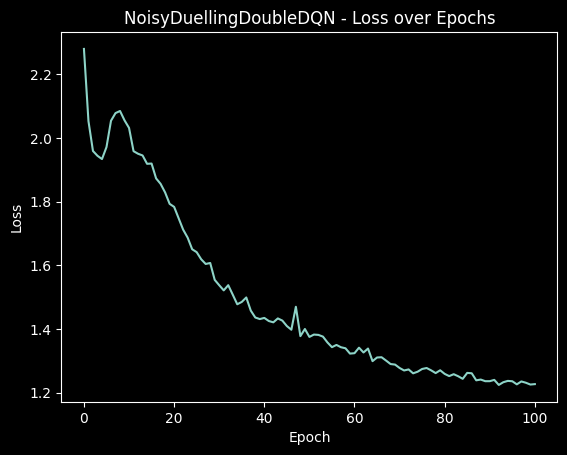

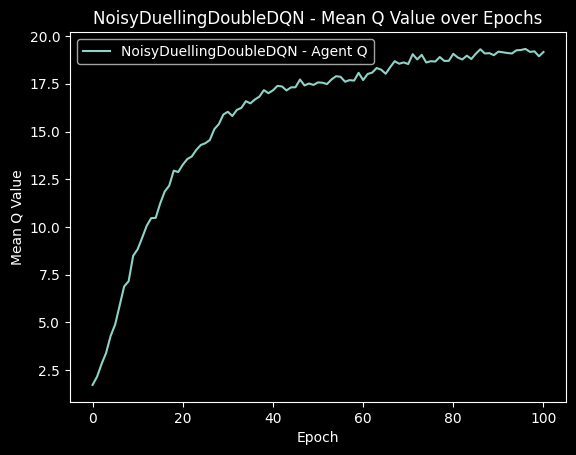

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os




# Loop through each model and create plots and save metrics
for model_name, model_list in models.items():
    # Get the records for this model
    loss_record = record_loss_z[model_name]
    agent_q_record = record_agent_q[model_name]
    phys_q_record = record_phys_q[model_name]

    # Plot and save loss over epochs
    x_length_list = list(range(len(loss_record)))
    plt.figure()
    plt.title(f'{model_name} - Loss over Epochs')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(x_length_list, loss_record)
    loss_path = save_path+f"/{model_name}"
    os.makedirs(loss_path, exist_ok=True)
    plt.savefig(f'{loss_path}/loss.png')
    np.save(f'{loss_path}/loss.npy', loss_record)
    plt.show()
    plt.close()

    # Plot and save Mean Agent Q value over epochs
    agent_length_list = list(range(len(agent_q_record)))
    plt.figure()
    plt.title(f'{model_name} - Mean Q Value over Epochs')
    plt.xlabel("Epoch")
    plt.ylabel("Mean Q Value")
    plt.plot(agent_length_list, agent_q_record, label=f'{model_name} - Agent Q')
    plt.legend()
    meanq_path = save_path+f"/{model_name}"
    os.makedirs(meanq_path, exist_ok=True)
    plt.savefig(f'{meanq_path}/mean_agent_q.png')
    np.save(f'{meanq_path}/mean_agent_q.npy', agent_q_record)
    plt.show()
    plt.close()

    # Save Mean Phys Q value (no plot)
    np.save(f'{meanq_path}/mean_phys_q.npy', phys_q_record)


In [26]:
patient_cluster_labels = patient_clusters_test['Patient Cluster'].values  
test_batchs = test_batchs + (tuple(patient_cluster_labels),)

In [27]:
import numpy as np
import os
# Perform testing for the current cluster
for model_name, model_list in models.items():
    if model_name == "ActorCritic":
        continue
        #do_test_ac(mimic_type, models[model_name], test_batchs, Y90_test, n_patient, ncl, cluster)
    else:
        do_test(model_name, mimic_type, models[model_name], test_batchs, Y90_test, n_patient, ncl, cluster)
print("Test set evaluation complete.")


Cluster user: [0. 0. 0. ... 1. 1. 1.]
rec_sur length: 1720, rec_agent_q length: 1720, rec_phys_q length: 1720
Cluster user: [0. 1. 1. ... 0. 0. 0.]
rec_sur length: 3322, rec_agent_q length: 3322, rec_phys_q length: 3322
Cluster user: [0. 0. 0. ... 1. 1. 0.]
rec_sur length: 4913, rec_agent_q length: 4913, rec_phys_q length: 4913
Cluster user: [0. 0. 1. ... 0. 0. 0.]
rec_sur length: 6612, rec_agent_q length: 6612, rec_phys_q length: 6612
Cluster user: [0. 0. 0. ... 1. 1. 1.]
rec_sur length: 8259, rec_agent_q length: 8259, rec_phys_q length: 8259
Cluster user: [0. 0. 0. ... 1. 1. 1.]
rec_sur length: 9941, rec_agent_q length: 9941, rec_phys_q length: 9941
Cluster user: [0. 0. 1. ... 0. 0. 0.]
rec_sur length: 11608, rec_agent_q length: 11608, rec_phys_q length: 11608
Cluster user: [0. 1. 1. ... 0. 1. 0.]
rec_sur length: 13377, rec_agent_q length: 13377, rec_phys_q length: 13377
Cluster user: [0. 0. 0. ... 0. 0. 0.]
rec_sur length: 14954, rec_agent_q length: 14954, rec_phys_q length: 14954
C